In [341]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoLarsIC
import matplotlib.pyplot as plt
import seaborn as sns

# Separating first 400 date_id as train set and the rest as test set

In [237]:
# data = pd.read_csv('train.csv')

In [238]:
# data['date_id'].unique()

In [239]:
# data['date_id'].value_counts().sort_index()# i.e. some earlier date_id have different value count than later date_id

In [240]:
# train_set, test_set = data[data['date_id']<=400], data[data['date_id']>400]

In [241]:
# train_set.to_csv('research_train_set.csv', index=False)
# train_set.to_csv('research_test_set.csv', index=False)

# Read in train and test set

In [242]:
train_set = pd.read_csv('research_train_set.csv')
test_set = pd.read_csv('research_test_set.csv')

In [243]:
print(len(train_set)/(len(train_set)+len(test_set)), len(test_set)/(len(train_set)+len(test_set)))# truely a 50% split

0.5 0.5


In [244]:
train_set.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


# Factor Ideas:
1. volatility weighted synthetic index: Target computation have its own synthetic index computation component.
2. historical beta: correlation between stock and index
3. AR1: target usually bonce between two periods. 
4. volatility: historical volatility of the stock will continue
5. order book imbalance shift around: how many times order books imbalance changes, indicates disagreement between buyers and sellers.
6. order book imbalance shift magnitude: small difference shift doesn't matter if the magnitude is small.
7. seconds_in_bucket: how stocks always perform in the same 10 seconds -> indicates possible algorithmic trading.
8. seconds_in_bucket volatility: historically how volatile the stock is in the same 10 seconds.
9. maximum bonce in x seconds: give the algo a feeling of how normal range should be
10. near price - far price: the difference of the market running auction or the market running auction + continous market trading.
11. (near price-far price)/ (far price* second in bucket): the percentage of the market running auction or the market running auction + continous market trading. indicator of market inefficiency. adjust for seconds in bucket.
12. time 0 and time 540 might be special: time 0: people may not be ready to trade, but algos are. time 540: last chance to trade.
13. spoofing: "fake orders" posted design to build order imbalance, so that it encourages the buy/sell of the stock such that it goes in the direction of the spoofer's order.
variance of the order book imbalance suggests spoofing. since we cannot cancel after 3:50, we can only do spoofing with both side large order that cancel each other out.

14. Rough fill probability: the probability for the best bid-ask price being filled. 
t=0, bid-ask price = 100-101. bid-ask vol = 1000-1000 
t=1, bid-ask price = 100-101. bid-ask vol = 500-500
then rough fill probability for bid-ask = 0.5 0.5
15. stock agreeableness: if the matching size is large relative to the order book imbalance size (compare to the cross-sectional median), then the buyer and seller agree on the price 
16. volume sitting on the order book (less best-bid-and-ask) = imbalance size - bid_size-ask_size
16. wap sitting on the order book: because wap is weighted average price for all order sitting on the order book,so we can extract parts that is not the best bid and ask price
17. best slot1 imbalance size: same calculation as imbalance size
18. difference in imbalance size: (imbalance_size-matched_size)/(matched_size+imbalance_size)
19. <s>spread: best ask price - best bid price. indicate the trading cost of crossing the spread.</s>
20. <s>spread difference: spread at time t - spread at time t-1. indicate the volatility of the spread.</s>
20. <s>spread volatility_ts: std of spread starting from first 5 observations of the day</s>
21. <s>deviation of price from the closing price (closing price is the price at second_in_basket 0) using mid price</s>
22. <s>volume imbalance at best-bid-and-ask: (bid_size-ask_size)/(bid_size+ask_size)</s>
23. <s>MOC flag: nasdaq don't accept moc order after 3:55. i.e. second in bucket >= 300</s>
23. longer memory: correlation with certain window.

In [245]:
def spread(df):
    """
    spread at the first slot
    :param df: training set (fixed for every factor) 
    :return: np.ndarray
    """
    res = df['ask_price']-df['bid_price']
    return res.values

In [246]:
def spread_diff(df):
    """
    spread difference between two observations
    :param df: training set (fixed for every factor) 
    :return: np.ndarray
    """
    res = df.loc[:,['stock_id','date_id','seconds_in_bucket']]
    res['spread'] = df['ask_price']-df['bid_price']
    res = res.groupby(['stock_id','date_id'])['spread'].diff().fillna(0)
    return res.values

In [247]:
def spread_vol_5(df):
    """
    spread volatility rolling 5 observations
    :param df: training set (fixed for every factor) 
    :return: np.ndarray
    """
    res = df.loc[:,['stock_id','date_id','seconds_in_bucket']]
    res['spread'] = df['ask_price']-df['bid_price']
    return res.groupby(['stock_id','date_id'])['spread'].rolling(5).std().reset_index().sort_values('level_2')['spread'].values# this sort value is important because it preserves the original order of the data

In [248]:
def s1_vol_imbalance(df):
    """
    volume imbalance at the first slot
    :param df: training set (fixed for every factor) 
    :return: np.ndarray
    """
    res = (df['bid_size']-df['ask_size'])/(df['bid_size']+df['ask_size'])
    return res.values

In [249]:
def MOC_flag(df):
    """
    MOC flag: after seconds_in_bucket >= 300, we cannot submit MOC order
    :param df: 
    :return: 
    """
    res = df['seconds_in_bucket'].apply(lambda x: 1 if x>=300 else 0)
    return res.values

In [250]:
def mid_price(df):
    """
    mid-price at the bba
    :param df: training set (fixed for every factor) 
    :return: np.ndarray
    """
    res = (df['bid_price']+df['ask_price'])/2
    return res.values

In [282]:
def mid_price_deviate_from_start(df):
    res = df.loc[:,['stock_id','date_id','bid_price','ask_price']]
    res['mid_price'] = mid_price(df)
    res['mid_price_deviate_from_start'] = res.groupby(['stock_id','date_id'])['mid_price'].transform('first')-res['mid_price']
    return res['mid_price_deviate_from_start'].values

# Call all factors

In [293]:
# original_factor = ['seconds_in_bucket', 'imbalance_size',
#        'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
#         'bid_price', 'bid_size', 'ask_price',
#        'ask_size', 'wap','far_price', 'near_price']#10 of them. far price and near price are excluded because 80% nan
original_factor = ['seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
        'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap']
factor_name = ['spread','spread_diff','spread_vol_5','s1_vol_imbalance','MOC_flag','mid_price','mid_price_deviate_from_start']

In [294]:
factors = {}

In [295]:
for factor in original_factor:
    factors[factor] = train_set[factor].values

In [296]:
for factor in factor_name:
    factors[factor] = eval(factor)(train_set)

In [297]:
factors = (np.vstack(list(factors.values())))

In [322]:
factors.shape

(17, 4357980)

# Analyse the quality of factors

In [323]:
import plotly.express as px

In [324]:
df = pd.DataFrame(np.vstack([factors,train_set['target'].values]).T, columns=original_factor+factor_name+['target'])
# df = pd.DataFrame(np.vstack([factors,train_set['target'].values]).T, columns=original_factor+factor_name+['target']).dropna()
# correlation heatmap
fig = px.imshow(abs(df.corr()),text_auto=True,aspect='auto',)
fig.update_layout(title='Correlation Heatmap')
fig.show()

In [325]:
abs_corr_w_target = abs(df.iloc[:,:-1].corrwith(df['target']))

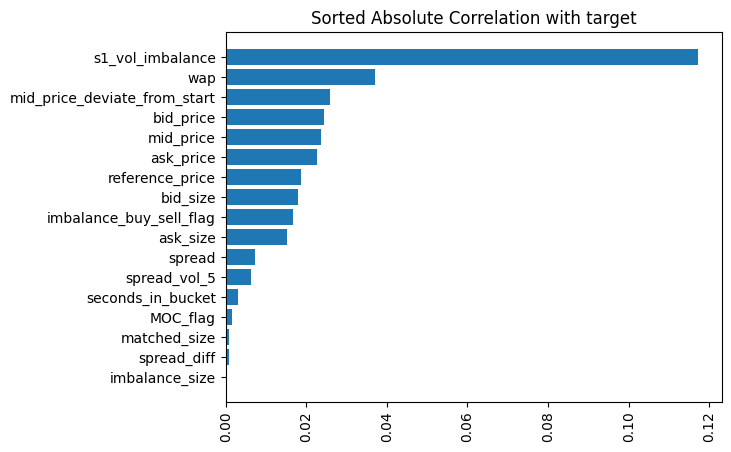

In [326]:
plt.barh(y = abs_corr_w_target.sort_values().index,width=abs_corr_w_target.sort_values(ascending=True))
plt.xticks(rotation=90)
plt.title('Sorted Absolute Correlation with target')
plt.show()

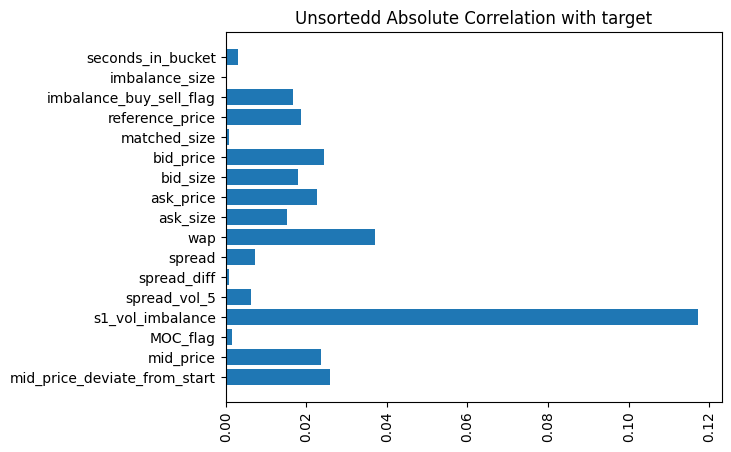

In [327]:
plt.barh(y = abs_corr_w_target.index[::-1],width=abs_corr_w_target[::-1])
plt.xticks(rotation=90)
plt.title('Unsortedd Absolute Correlation with target')
plt.show()

In [344]:
from sklearn.preprocessing import MinMaxScaler

In [352]:
model = LassoLarsIC(criterion='bic')
dropna_df = df.dropna()
scaled_factors = MinMaxScaler().fit_transform(dropna_df.iloc[:,:-1])
model.fit(y = dropna_df['target'],X = scaled_factors)

LassoLarsIC(criterion='bic')

<BarContainer object of 17 artists>

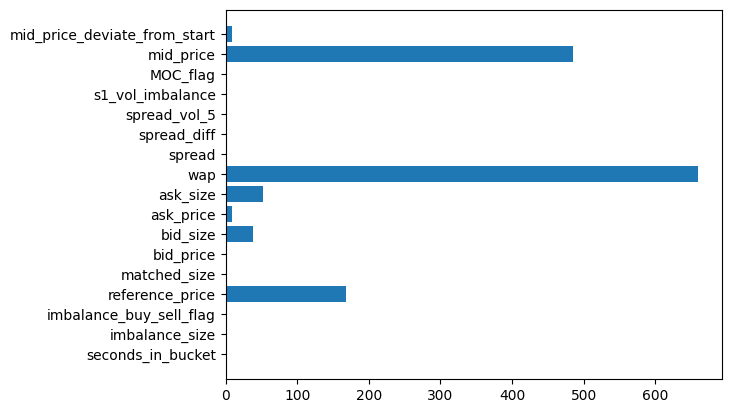

In [353]:
plt.barh(y = dropna_df.columns[:-1],width = abs(model.coef_))

In [355]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()
model.fit(y = dropna_df['target'],X = scaled_factors)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.320088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 4040883, number of used features: 17
[LightGBM] [Info] Start training from score -0.058384


LGBMRegressor()

<Axes: >

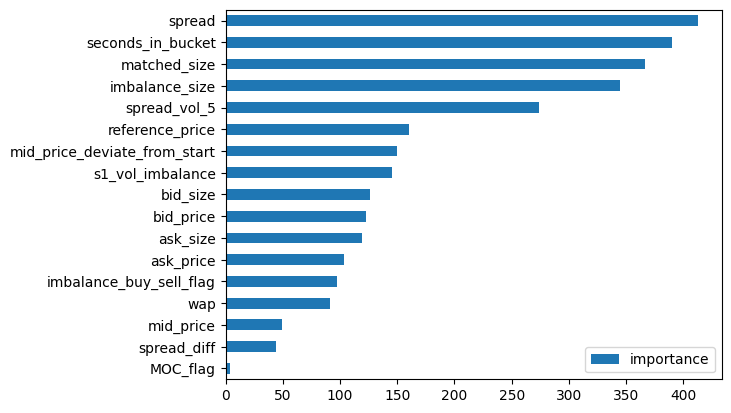

In [382]:
feature_importance = pd.DataFrame(model.feature_importances_,index=dropna_df.columns[:-1],columns=['importance']).sort_values('importance',ascending=True)
feature_importance.plot(kind='barh')

In [384]:
model.score(y = dropna_df['target'],X = scaled_factors)

0.0474803813773772

# sketch

In [ ]:
res = test_set.loc[:,['stock_id','date_id','bid_price','ask_price']]
res['mid_price'] = mid_price(test_set)

In [ ]:
res.groupby(['stock_id','date_id'])['wap'].first()

In [ ]:
(res.groupby(['stock_id','date_id'])['mid_price'].transform('first')-res['mid_price']).iloc[573]
# res[(res['stock_id']==0) & (res['date_id']==3)].groupby(['stock_id','date_id'])['mid_price'].transform('first')

In [ ]:
res[res['stock_id']==0]